In [0]:
# install keras first
!pip install dill
!pip install -q keras


In [0]:
import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu,floatX=float32"


In [0]:
from keras import backend as K
if K.backend()=='tensorflow':
    K.set_image_dim_ordering("th")

Using TensorFlow backend.


In [0]:
batch_size = 256
num_classes = 100
'''
epochs_longrun = 500
save_dir = "/work"
res_dir = "/results"
model_name = 'convnet_cifar100'
'''

'\nepochs_longrun = 500\nsave_dir = "/work"\nres_dir = "/results"\nmodel_name = \'convnet_cifar100\'\n'

In [0]:
from __future__ import print_function
import tensorflow as tf
import keras
from keras.datasets import cifar100
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D
from keras.optimizers import Adam
from keras.layers.pooling import MaxPooling2D
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.utils import to_categorical
from keras.models import load_model

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import *
import warnings
warnings.filterwarnings('ignore')

In [0]:
tf.reset_default_graph()
tf.set_random_seed(343)
np.random.seed(343)
# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()   # point!!!!
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 3, 32, 32)
50000 train samples
10000 test samples


In [0]:
# Convert class vectors to binary class matrices.
y_train_c = to_categorical(y_train, num_classes)
y_test_c = to_categorical(y_test, num_classes)
#Normalize data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.0    
x_test /= 255.0

In [0]:
# Let's see what values are in the label y_train
np.unique(y_train)   # target is hundred classes

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [0]:
coarse_label = [
'apple', # id 0
'aquarium_fish',
'baby',
'bear',
'beaver',
'bed',
'bee',
'beetle',
'bicycle',
'bottle',
'bowl',
'boy',
'bridge',
'bus',
'butterfly',
'camel',
'can',
'castle',
'caterpillar',
'cattle',
'chair',
'chimpanzee',
'clock',
'cloud',
'cockroach',
'couch',
'crab',
'crocodile',
'cup',
'dinosaur',
'dolphin',
'elephant',
'flatfish',
'forest',
'fox',
'girl',
'hamster',
'house',
'kangaroo',
'computer_keyboard',
'lamp',
'lawn_mower',
'leopard',
'lion',
'lizard',
'lobster',
'man',
'maple_tree',
'motorcycle',
'mountain',
'mouse',
'mushroom',
'oak_tree',
'orange',
'orchid',
'otter',
'palm_tree',
'pear',
'pickup_truck',
'pine_tree',
'plain',
'plate',
'poppy',
'porcupine',
'possum',
'rabbit',
'raccoon',
'ray',
'road',
'rocket',
'rose',
'sea',
'seal',
'shark',
'shrew',
'skunk',
'skyscraper',
'snail',
'snake',
'spider',
'squirrel',
'streetcar',
'sunflower',
'sweet_pepper',
'table',
'tank',
'telephone',
'television',
'tiger',
'tractor',
'train',
'trout',
'tulip',
'turtle',
'wardrobe',
'whale',
'willow_tree',
'wolf',
'woman',
'worm',
]

medium_sized_mammals_index = [ coarse_label.index(x) for x in ['fox', 'porcupine', 'possum', 'raccoon', 'skunk'] ]
small_mammals_index = [ coarse_label.index(x) for x in ['hamster', 'mouse', 'rabbit', 'shrew', 'squirrel'] ]

medium_sized_remaining_mammals_index3 = [ coarse_label.index(x) for x in ['possum', 'porcupine','raccoon'] ]   ######
small_remaining_mammals_index3 = [ coarse_label.index(x) for x in ['mouse', 'hamster','rabbit'] ]  #######

medium_sized_rest_mammals_index3 = [ coarse_label.index(x) for x in ['skunk','fox'] ]   ###### new
small_rest_mammals_index3 = [ coarse_label.index(x) for x in ['shrew', 'squirrel'] ]  #######new

remaining_mammals_index = medium_sized_remaining_mammals_index3 + small_remaining_mammals_index3   ######
print (medium_sized_mammals_index, small_mammals_index, remaining_mammals_index)

[34, 63, 64, 66, 75] [36, 50, 65, 74, 80] [64, 63, 66, 50, 36, 65]


In [0]:
x = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))

remaining_mammals_slice = np.array([ idx for idx, v in enumerate(y) if v[0] in remaining_mammals_index ])
rest_mammals_slice = np.array([ idx for idx, v in enumerate(y) if v[0] in (set(medium_sized_mammals_index) | set(small_mammals_index)) - set(remaining_mammals_index) ])

x_remaining_mammals = x[remaining_mammals_slice]
y_remaining_mammals = y[remaining_mammals_slice]
y_remaining_mammals_bin = np.array([ [int(y[0] in medium_sized_remaining_mammals_index3)] for y in y_remaining_mammals ])

# rest part for "not see animal "test
x_rest_mammals = x[rest_mammals_slice]
y_rest_mammals = y[rest_mammals_slice]
y_rest_mammals_bin = np.array([ [int(y[0] in medium_sized_rest_mammals_index3)] for y in y_rest_mammals ])  ####new
print(y_rest_mammals_bin)

print (x_remaining_mammals.shape, y_remaining_mammals.shape)
print (x_rest_mammals.shape, y_rest_mammals.shape)
print (y_remaining_mammals_bin.shape, y_rest_mammals_bin.shape)

from sklearn.model_selection import train_test_split

# the data will work on 
x_remaining_mammals_train, x_remaining_mammals_test, y_remaining_mammals_train, y_remaining_mammals_test = \
  train_test_split(x_remaining_mammals, y_remaining_mammals_bin, test_size=0.2, random_state=42)

print (x_remaining_mammals_train.shape, x_remaining_mammals_test.shape)
print (y_remaining_mammals_train.shape, y_remaining_mammals_test.shape)

[[0]
 [0]
 [1]
 ...
 [0]
 [0]
 [1]]
(3600, 3, 32, 32) (3600, 1)
(2400, 3, 32, 32) (2400, 1)
(3600, 1) (2400, 1)
(2880, 3, 32, 32) (720, 3, 32, 32)
(2880, 1) (720, 1)


In [0]:
# ten classes label
target_label = {34: 'fox', 63: 'porcupine', 64: 'possum', 66: 'raccoon', 75: 'skunk', 36: 'hamster', 50: 'mouse', 65: 'rabbit', 74: 'shrew', 80: 'squirrel'}

In [0]:
small_mammals = ['hamster', 'mouse', 'rabbit', 'shrew', 'squirrel']
medium_sized_mammals = ['fox', 'porcupine', 'possum', 'raccoon', 'skunk']

In [0]:
def cifar_grid2(X,Y,inds,n_col,predictions):  #print out randomly selected images and their labels  
  N = len(inds)
  n_row = int(ceil(1.0*N/n_col))
  fig = plt.figure(figsize=(15, 20))
  #count=0
  #l=list()
# align labels in the right order  #encode the target class
  clabels = ['small_mammals','medium_sized_mammal']
  #print(type(clabels))
  for j in range(n_row):
    for k in range(n_col):
      i_inds = (j*n_col)+k
      i_data = inds[i_inds]
     
      if i_inds < N:
        rgb = X[[i_data,...]]
        #test_label=test_list[0] if clabels[Y[i_data][0]]=='small_mammals' else test_list[1]  
        label =clabels[Y[i_data][0]]
        img = rgb.reshape(3,32,32).transpose([1, 2, 0])
        fig.add_subplot(n_row,n_col, i_inds+1)
        #pred = clabels[np.argmax(predictions[i_data,...])]
        pred = clabels[predictions[i_data]]
        plt.imshow(img, interpolation='nearest')
        plt.title("actual: {}\n predict: {}".format(label,pred))  
        #if label==pred:
        #  count+=1
        #  l.append(j*4+k)
  #print(count)
  #print(l)
         
  fig.set_tight_layout(True)

In [0]:
# choose 36 img randomly
indices = [np.random.choice(range(len(y_remaining_mammals_test))) for i in range(36)]
print (indices)



[625, 146, 108, 22, 150, 644, 294, 663, 65, 659, 497, 116, 563, 555, 218, 430, 125, 676, 330, 92, 114, 402, 39, 364, 152, 62, 491, 659, 691, 591, 563, 154, 164, 566, 281, 644]


# **Loop**

In [0]:
# slect two from each superclass
def select_two(mammals_list):
  mammals_two=list()
  for i in range(0,5):
    for j in range(i+1,5):
      mammals_two.append([mammals_list[i],mammals_list[j]])
  return mammals_two

In [0]:
small_two=select_two(small_mammals)
medium_two=select_two(medium_sized_mammals)
#len(medium_two)

In [0]:
def train_test_2(small,medium): # test class for small and med
  small_mammals = ['hamster', 'mouse', 'rabbit', 'shrew', 'squirrel']
  small_mammals.remove(small[0])
  small_mammals.remove(small[1])
  medium_sized_mammals = ['fox', 'porcupine', 'possum', 'raccoon', 'skunk']
  medium_sized_mammals.remove(medium[0])
  medium_sized_mammals.remove(medium[1])
  
  # For training set
  medium_ind = [ coarse_label.index(x) for x in medium_sized_mammals ]
  small_ind = [ coarse_label.index(x) for x in small_mammals ]
  target_ind = medium_ind + small_ind

  #print ("Training set-\nNew index of Medium-sized mammals:", medium_ind,"\nNew index of Small mammals:", small_ind)

  # For testing data - 
  medium_ind_2 = [ coarse_label.index(x) for x in medium ]
  small_ind_2 = [ coarse_label.index(x) for x in small ]
  target_ind_2 = medium_ind_2 + small_ind_2
  #print ("\nTesting set-\nNew index of Medium-sized mammals:", medium_ind_2,"\nNew index of Small mammals:", small_ind_2)
  
  # Splice the dataset to extract the relevant portion of data
  train_slice3 = np.array([ idx for idx, y in enumerate(y) if y[0] in target_ind])
  y_train4 = y[train_slice3]
  x_train4 = x[train_slice3]

  # Test set
  test_slice3 = np.array([ idx for idx, y in enumerate(y) if y[0] in target_ind_2])
  y_test4 = y[test_slice3]
  x_test4 = x[test_slice3]

  print ("Training set:", np.unique(y_train4))
  print ("\nTesting set:", np.unique(y_test4))
  #  Binary as we are working with two superclasses labels (or coarse labels)
  y_train_bin4 = np.array([[int(y[0] in medium_ind)] for y in y_train4])
  y_test_bin4 = np.array([[int(y[0] in medium_ind_2)] for y in y_test4])
  y_bin4 = np.concatenate((y_train_bin4,y_test_bin4)) # for two superclass
  
  return x_train4,x_test4,y_train_bin4,y_test_bin4

In [0]:
# create list for train and test

x_train4=list()
x_test4=list()
y_train_bin4=list()
y_test_bin4=list()
test_list2=list()  
for i in range(0,10):
  for j in range(0,10):
    small=small_two[i]
    medium=medium_two[j]
    x_train_temp,x_test_temp,y_train_temp,y_test_temp=train_test_2(small,medium)
    x_train4.append(x_train_temp)
    x_test4.append(x_test_temp)
    y_train_bin4.append(y_train_temp)
    y_test_bin4.append(y_test_temp)
    test_list2.append([small,medium])  


Training set: [64 65 66 74 75 80]

Testing set: [34 36 50 63]
Training set: [63 65 66 74 75 80]

Testing set: [34 36 50 64]
Training set: [63 64 65 74 75 80]

Testing set: [34 36 50 66]
Training set: [63 64 65 66 74 80]

Testing set: [34 36 50 75]
Training set: [34 65 66 74 75 80]

Testing set: [36 50 63 64]
Training set: [34 64 65 74 75 80]

Testing set: [36 50 63 66]
Training set: [34 64 65 66 74 80]

Testing set: [36 50 63 75]
Training set: [34 63 65 74 75 80]

Testing set: [36 50 64 66]
Training set: [34 63 65 66 74 80]

Testing set: [36 50 64 75]
Training set: [34 63 64 65 74 80]

Testing set: [36 50 66 75]
Training set: [50 64 66 74 75 80]

Testing set: [34 36 63 65]
Training set: [50 63 66 74 75 80]

Testing set: [34 36 64 65]
Training set: [50 63 64 74 75 80]

Testing set: [34 36 65 66]
Training set: [50 63 64 66 74 80]

Testing set: [34 36 65 75]
Training set: [34 50 66 74 75 80]

Testing set: [36 63 64 65]
Training set: [34 50 64 74 75 80]

Testing set: [36 63 65 66]
Training

In [0]:
# x_train4_ = [x_train4[i].reshape(x_train4[i].shape[0],3*32*32) for i in range(0,100)]
# x_test4_ = [x_test4[i].reshape(x_test4[i].shape[0],3*32*32) for i in range(0,100)]
# len(x_train4_)

100 trials:

x_train4_

x_test4_

y_train_bin4

y_test_bin4

In [0]:
"""from sklearn.ensemble import BaggingClassifier
start = time.time()
bag = BaggingClassifier()
bag.fit(x_train4_[0], y_train_bin4[0])
bag_pred=bag.predict(x_test4_[0])
print ("Accuracy ({}, {}): {}%".format(test_list2[0][0],test_list2[0][1] ,bag.score(x_test4_[0], y_test_bin4[0])*100)) 
end = time.time()"""

'from sklearn.ensemble import BaggingClassifier\nstart = time.time()\nbag = BaggingClassifier()\nbag.fit(x_train4_[0], y_train_bin4[0])\nbag_pred=bag.predict(x_test4_[0])\nprint ("Accuracy ({}, {}): {}%".format(test_list2[0][0],test_list2[0][1] ,bag.score(x_test4_[0], y_test_bin4[0])*100)) \nend = time.time()'

#Loop for 3 pairs

In [0]:
# # slect two from each superclass
# def select_two(mammals_list):
#   mammals_two=list()
#   for i in range(0,5):
#     for j in range(i+1,5):
#       mammals_two.append([mammals_list[i],mammals_list[j]])
#   return mammals_two

In [0]:
# small_two=select_two(small_mammals)
# medium_two=select_two(medium_sized_mammals)
# #len(medium_two)

In [0]:
# def train_test_2(small,medium): # test class for small and med
#   small_mammals = ['hamster', 'mouse', 'rabbit', 'shrew', 'squirrel']
#   small_mammals.remove(small[0])
#   small_mammals.remove(small[1])
#   medium_sized_mammals = ['fox', 'porcupine', 'possum', 'raccoon', 'skunk']
#   medium_sized_mammals.remove(medium[0])
#   medium_sized_mammals.remove(medium[1])
  
#   # For training set
#   medium_ind = [ coarse_label.index(x) for x in medium_sized_mammals ]
#   small_ind = [ coarse_label.index(x) for x in small_mammals ]
#   target_ind = medium_ind + small_ind

#   #print ("Training set-\nNew index of Medium-sized mammals:", medium_ind,"\nNew index of Small mammals:", small_ind)

#   # For testing data - 
#   medium_ind_2 = [ coarse_label.index(x) for x in medium ]
#   small_ind_2 = [ coarse_label.index(x) for x in small ]
#   target_ind_2 = medium_ind_2 + small_ind_2
#   #print ("\nTesting set-\nNew index of Medium-sized mammals:", medium_ind_2,"\nNew index of Small mammals:", small_ind_2)
  
#   # Splice the dataset to extract the relevant portion of data
#   train_slice3 = np.array([ idx for idx, y in enumerate(y) if y[0] in target_ind])
#   y_train4 = y[train_slice3]
#   x_train4 = x[train_slice3]

#   # Test set
#   test_slice3 = np.array([ idx for idx, y in enumerate(y) if y[0] in target_ind_2])
#   y_test4 = y[test_slice3]
#   x_test4 = x[test_slice3]

#   #print ("Training set:", np.unique(y_train4))
#   #print ("\nTesting set:", np.unique(y_test4))
#   #  Binary as we are working with two superclasses labels (or coarse labels)
#   y_train_bin4 = np.array([[int(y[0] in medium_ind)] for y in y_train4])
#   y_test_bin4 = np.array([[int(y[0] in medium_ind_2)] for y in y_test4])
#   y_bin4 = np.concatenate((y_train_bin4,y_test_bin4)) # for two superclass
  
#   return x_train4,x_test4,y_train_bin4,y_test_bin4

In [0]:
# # create list for train and test
# # train,test=test,train
# x_train5=list()
# x_test5=list()
# y_train_bin5=list()
# y_test_bin5=list()
# train_list=list()  
# for i in range(0,10):
#   for j in range(0,10):
#     small=small_two[i]
#     medium=medium_two[j]
#     x_test_temp,x_train_temp,y_test_temp,y_train_temp=train_test_2(small,medium)
#     x_train5.append(x_train_temp)
#     x_test5.append(x_test_temp)
#     y_train_bin5.append(y_train_temp)
#     y_test_bin5.append(y_test_temp)
#     train_list.append([small,medium])  


In [0]:
train_list

NameError: ignored

In [0]:
# y_train_bin4_c = to_categorical(y_train_bin4[0])
# y_test_bin4_c = to_categorical(y_test_bin4[0])
# y_train_bin4_c.shape 

In [0]:
from google.colab import drive
from keras.models import load_model
drive.mount('/content/gdrive')

In [0]:
model = load_model('/content/gdrive/My Drive/CMPE 257 project/Milestone 3/my_model4.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [0]:
from keras.utils import plot_model
plot_model(model, to_file='/content/gdrive/My Drive/model.png')

In [0]:
range(2,100)

In [0]:
model.summary()

In [0]:
for i in range(60,100):
  model = load_model('/content/gdrive/My Drive/CMPE 257 project/Milestone 3/my_model4.h5')
  lr = 0.0001
  opt = Adam(lr=lr, decay=1e-6)

  model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
  
  x_train = x_train5[i]
  x_test = x_test5[i]
  y_train_bin_c = to_categorical(y_train_bin5[i])
  y_test_bin_c = to_categorical(y_test_bin5[i])

  hist= model.fit(x_train, y_train_bin_c,validation_data=(x_test, y_test_bin_c), epochs=15)
  scores = model.evaluate(x_test, y_test_bin_c, verbose=0)
  
  print("trial ", i, " result: score: %.2f%%" % (scores[1]*100))

In [0]:
i = 19
model = load_model('/content/gdrive/My Drive/CMPE 257 project/Milestone 3/my_model4.h5')
lr = 0.0001
opt = Adam(lr=lr, decay=1e-6)

model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
  
x_train = x_train4[i]
x_test = x_test4[i]
y_train_bin_c = to_categorical(y_train_bin4[i])
y_test_bin_c = to_categorical(y_test_bin4[i])

hist= model.fit(x_train, y_train_bin_c,validation_data=(x_test, y_test_bin_c), epochs=20)
scores = model.evaluate(x_test, y_test_bin_c, verbose=0)
  
print("trial ", i, " result: score: %.2f%%" % (scores[1]*100))

Train on 3600 samples, validate on 2400 samples
Epoch 1/20
3600/3600 [==============================] - 3s 877us/step - loss: 0.5436 - acc: 0.7322 - val_loss: 0.3714 - val_acc: 0.8421
Epoch 2/20
3600/3600 [==============================] - 1s 305us/step - loss: 0.5364 - acc: 0.7347 - val_loss: 0.4130 - val_acc: 0.8179
Epoch 3/20
3600/3600 [==============================] - 1s 305us/step - loss: 0.5201 - acc: 0.7467 - val_loss: 0.4247 - val_acc: 0.7992
Epoch 4/20
3600/3600 [==============================] - 1s 308us/step - loss: 0.5243 - acc: 0.7517 - val_loss: 0.4139 - val_acc: 0.8175
Epoch 5/20
3168/3600 [=========================>....] - ETA: 0s - loss: 0.5087 - acc: 0.7497

KeyboardInterrupt: ignored

In [0]:
def plot_model_history(model_history):
   fig, axs = plt.subplots(1,2,figsize=(15,5))
   # summarize history for accuracy
   axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
   axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
   axs[0].set_title('Model Accuracy')
   axs[0].set_ylabel('Accuracy')
   axs[0].set_xlabel('Epoch')
   axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
   axs[0].legend(['train', 'test'], loc='best')
   # summarize history for loss
   axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
   axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
   axs[1].set_title('Model Loss')
   axs[1].set_ylabel('Loss')
   axs[1].set_xlabel('Epoch')
   axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
   axs[1].legend(['train', 'test'], loc='best')
   plt.show()

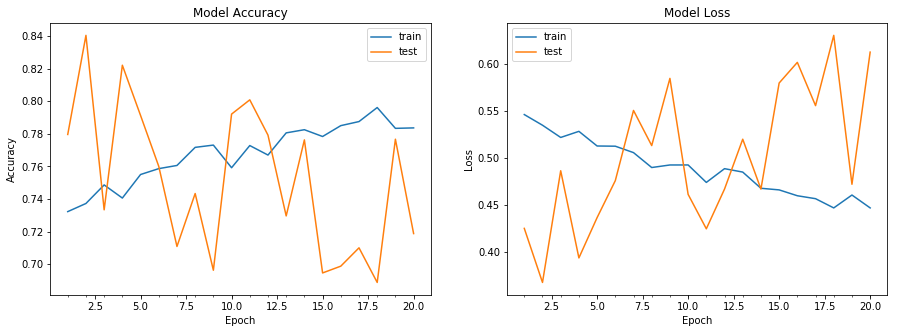

In [0]:
plot_model_history(hist)

In [0]:
y_predict = model.predict(x_test)
y_pred = np.argmax(y_predict, axis=1)

In [0]:
from sklearn.metrics import confusion_matrix
import pandas as pd
confusion_df = pd.DataFrame(confusion_matrix(np.argmax(y_test_bin_c, axis=1), y_pred),
                           columns=["Predicted Class " + str(class_name) for class_name in ['Small Mammals', 'Medium sized Mammals']],
                           index = ['Class ' + str(class_name) for class_name in ['Small Mammals', 'Medium sized Mammals']])
print(confusion_df)

                            Predicted Class Small Mammals  \
Class Small Mammals                                   906   
Class Medium sized Mammals                            190   

                            Predicted Class Medium sized Mammals  
Class Small Mammals                                          294  
Class Medium sized Mammals                                  1010  


In [0]:
from sklearn.metrics import classification_report
target_names = ['Small Mammals', 'Medium sized Mammals']
print(classification_report(np.argmax(y_test_bin_c, axis = 1), y_pred, target_names=target_names))

                      precision    recall  f1-score   support

       Small Mammals       0.83      0.76      0.79      1200
Medium sized Mammals       0.77      0.84      0.81      1200

           micro avg       0.80      0.80      0.80      2400
           macro avg       0.80      0.80      0.80      2400
        weighted avg       0.80      0.80      0.80      2400



In [0]:
def cifar_grid2(X,Y,inds,n_col,predictions):  #print out randomly selected images and their labels  
  N = len(inds)
  n_row = int(ceil(1.0*N/n_col))
  fig = plt.figure(figsize=(15, 20))
  #count=0
  #l=list()
# align labels in the right order  #encode the target class
  clabels = ['small_mammals','medium_mammals']
  #print(type(clabels))
  for j in range(n_row):
    for k in range(n_col):
      i_inds = (j*n_col)+k
      i_data = inds[i_inds]
     
      if i_inds < N:
        rgb = X[[i_data,...]]
        #test_label=test_list[0] if clabels[Y[i_data][0]]=='small_mammals' else test_list[1]  
        label =clabels[Y[i_data][0]]
        img = rgb.reshape(3,32,32).transpose([1, 2, 0])
        fig.add_subplot(n_row,n_col, i_inds+1)
        #pred = clabels[np.argmax(predictions[i_data,...])]
        pred = clabels[predictions[i_data]]
        plt.imshow(img, interpolation='nearest')
        title_obj = plt.title("actual: {}\n predict: {}".format(label,pred))
        if label != pred:
          plt.setp(title_obj, color='r') 
        else:
          plt.setp(title_obj, color='k') 
        #plt.title("actual: {}\n predict: {}".format(label,pred))  
        #if label==pred:
        #  count+=1
        #  l.append(j*4+k)
  #print(count)
  #print(l)
         
  fig.set_tight_layout(True)

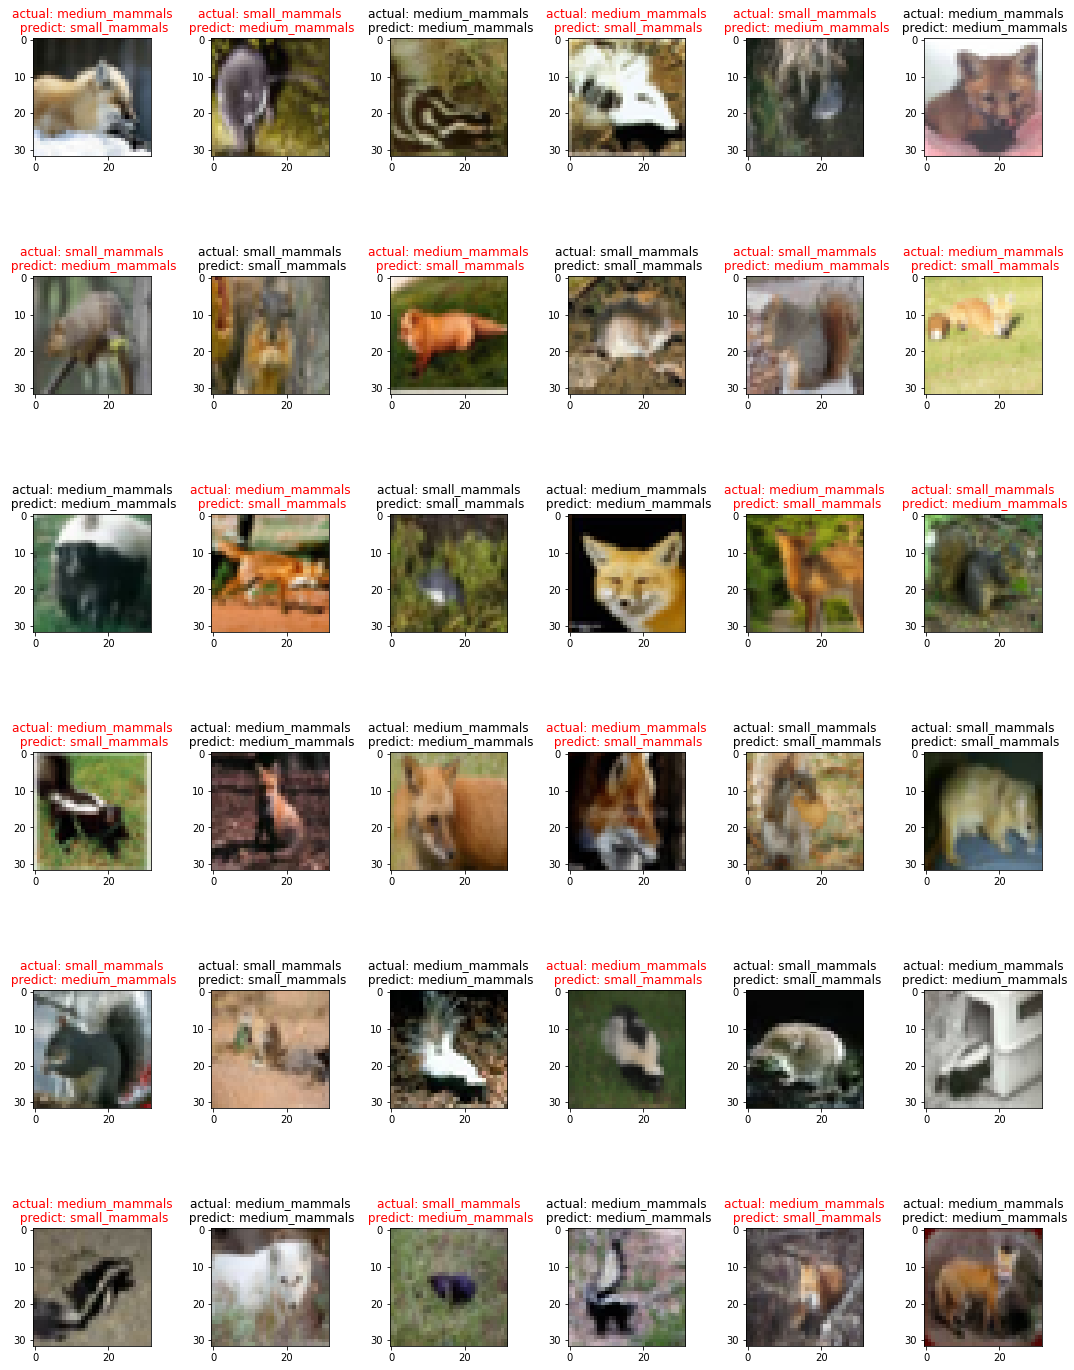

In [0]:
indices = [np.random.choice(range(len(x_rest_mammals))) for j in range(36)]
cifar_grid2(x_rest_mammals, y_rest_mammals_bin, indices,6,y_pred)